In [82]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder

%matplotlib inline
style.use('seaborn')

In [56]:
nba_teams = pd.DataFrame(teams.get_teams())
nba_teams.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [57]:
team_ids = nba_teams['id'].unique()
team_ids

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

In [38]:
main_df = pd.DataFrame()
for team_id in team_ids:
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
    games = gamefinder.get_data_frames()[0]
    games = games[games['GAME_DATE'] > '2014-09-01'] # the NBA season usually starts around october
    main_df = main_df.append(games)

main_df = main_df.sort_values('GAME_DATE',ascending=False)
main_df['EFG'] = ( main_df['FGM'] + 0.5 * main_df['FG3M'] ) / main_df['FGA'] # manual calculation as the api does not provide it, formula taken from google

In [44]:
main_df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,EFG
0,22020,1610612761,TOR,Toronto Raptors,0022000175,2021-01-14,TOR vs. CHA,W,242,111,...,13.0,27.0,40.0,33,13.0,6,17,16,9.6,0.568182
0,22020,1610612748,MIA,Miami Heat,0022000174,2021-01-14,MIA @ PHI,L,241,108,...,9.0,32.0,41.0,28,4.0,1,20,19,-17.4,0.567901
0,22020,1610612744,GSW,Golden State Warriors,0022000177,2021-01-14,GSW @ DEN,L,240,104,...,5.0,38.0,43.0,29,9.0,4,19,25,-11.6,0.537037
0,22020,1610612766,CHA,Charlotte Hornets,0022000175,2021-01-14,CHA @ TOR,L,240,108,...,14.0,30.0,44.0,32,11.0,5,18,15,-9.6,0.568966
0,22020,1610612755,PHI,Philadelphia 76ers,0022000174,2021-01-14,PHI vs. MIA,W,239,125,...,5.0,30.0,35.0,27,15.0,3,18,22,16.2,0.640244


## Data cleaning

What columns do we have?

In [45]:
main_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'EFG'],
      dtype='object')

How many data points do we have?

In [51]:
main_df.groupby(main_df.SEASON_ID.str[-4:])[['GAME_ID']].count()

,GAME_ID
SEASON_ID,
2014,2847
2015,3022
2016,2998
2017,2959
2018,2957
2019,2680
2020,440


30*82 = 2460, which does not tally with the table above. This implies that we have some pre and post season games in the data. Let's get it out by manually cleaning the data

In [54]:
#2014 season dates
start_2014 = '2014-10-28'
end_2014 = '2015-04-15'

#2015 season dates
start_2015 = '2015-10-27'
end_2015 = '2016-04-13'

#2016 season dates
start_2016 = '2016-10-25'
end_2016 = '2017-04-12'

#2017 season dates
start_2017 = '2017-10-17'
end_2017 = '2018-04-11'

#2018 season dates
start_2018 = '2018-10-16'
end_2018 = '2019-04-10'

#2019 season dates
start_2019 = '2019-10-22'
end_2019 = '2020-03-11' #ends earlier cos after that we head into the bubble

#2020 season dates
start_2020 = '2020-12-22'


In [62]:
#Repulling the data and computing everything
adjusted_main_df = pd.DataFrame()
for team_id in team_ids:
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
    games = gamefinder.get_data_frames()[0]
    games = games[(games['GAME_DATE'].between(start_2014,end_2014)) | (games['GAME_DATE'].between(start_2015,end_2015)) | (games['GAME_DATE'].between(start_2016,end_2016)) | (games['GAME_DATE'].between(start_2017,end_2017)) | (games['GAME_DATE'].between(start_2018,end_2018)) | (games['GAME_DATE'].between(start_2019,end_2019)) | (games['GAME_DATE']>start_2020)]
    adjusted_main_df = adjusted_main_df.append(games)

adjusted_main_df = adjusted_main_df.sort_values('GAME_DATE',ascending=False)
adjusted_main_df['EFG'] = ( adjusted_main_df['FGM'] + 0.5 * adjusted_main_df['FG3M'] ) / adjusted_main_df['FGA']

In [63]:
adjusted_main_df.groupby(adjusted_main_df.SEASON_ID.str[-4:])[['GAME_ID']].count()

,GAME_ID
SEASON_ID,
2014,2460
2015,2460
2016,2460
2017,2460
2018,2460
2019,1942
2020,338


In [64]:
# checking for any null values, looks like all is well 
adjusted_main_df.isnull().sum()

SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
GAME_ID              0
GAME_DATE            0
MATCHUP              0
WL                   0
MIN                  0
PTS                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PLUS_MINUS           0
EFG                  0
dtype: int64

Now the data is clean and ready to be used for further analysis.

We would like to understand how the distribution of each of the features has changes over the years

In [105]:
features_of_interest = ['PTS','EFG','FG_PCT','FG3_PCT','FT_PCT','REB','OREB','DREB','AST','STL','BLK','TOV']
print('No. of features of interest:',len(features_of_interest))

No. of features of interest: 12


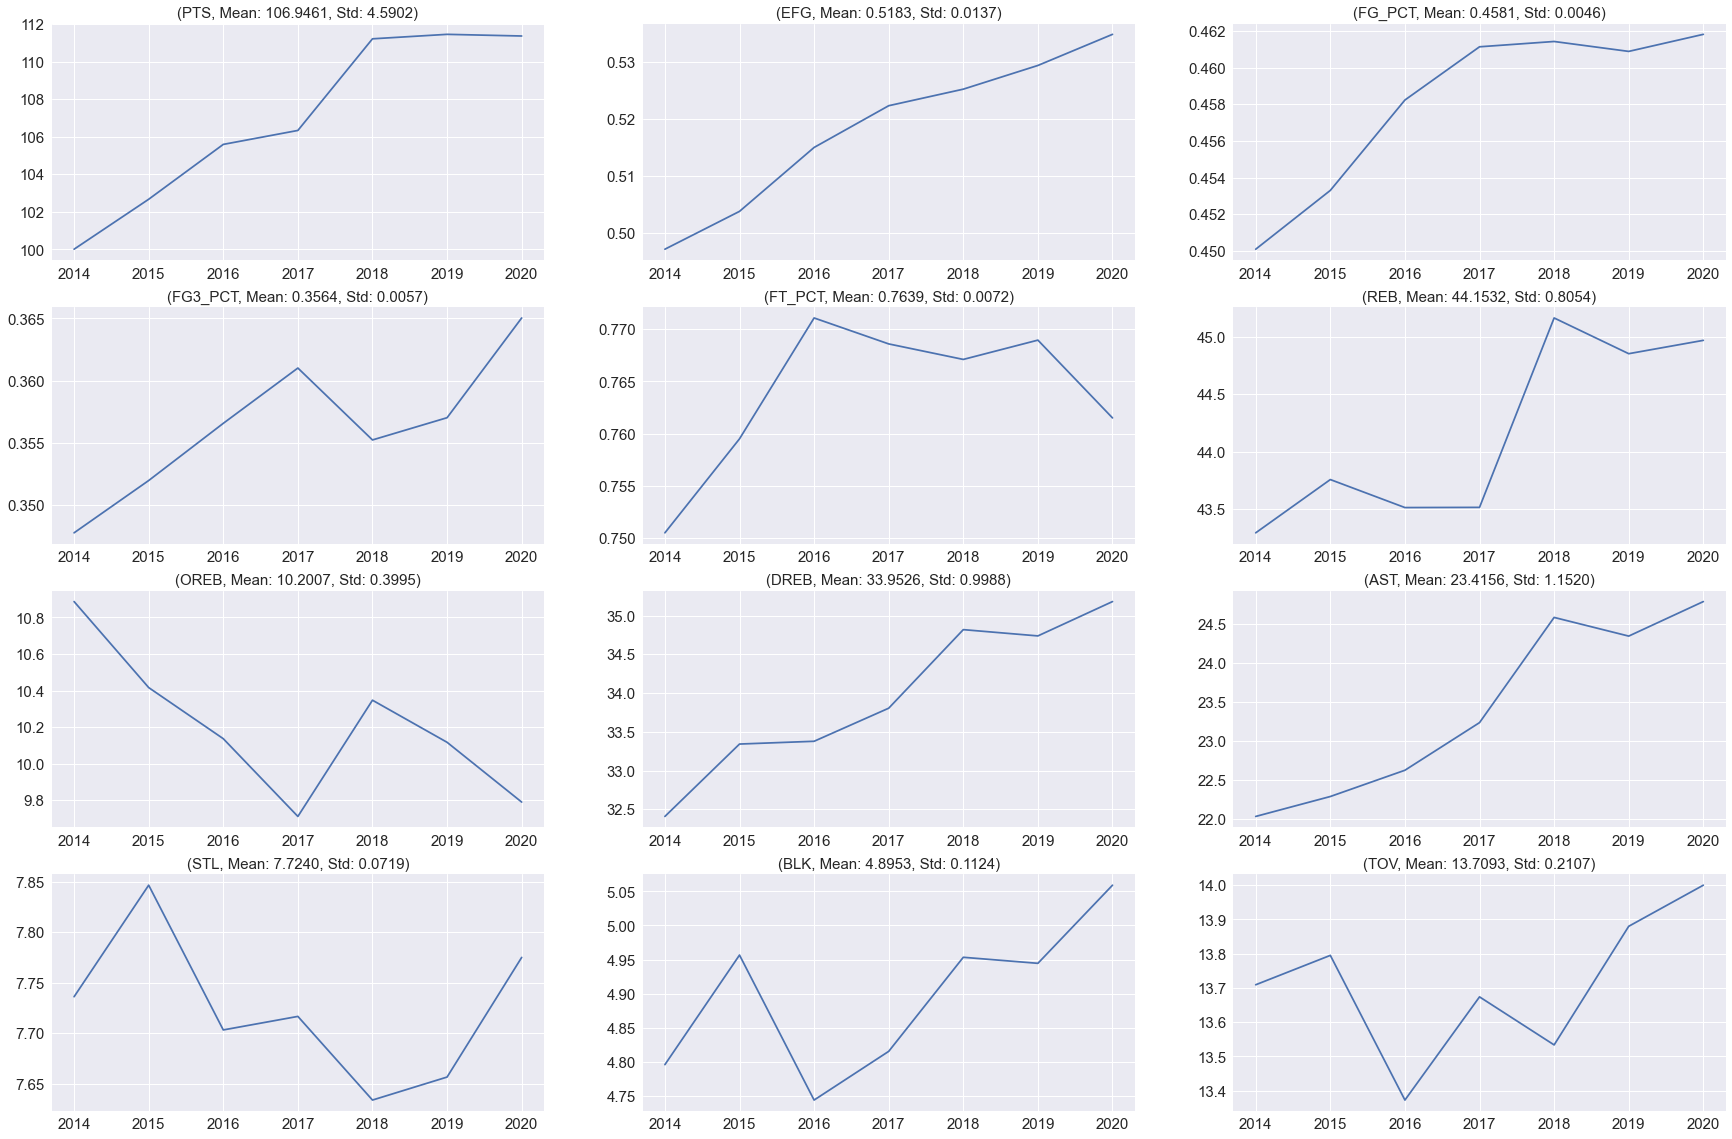

In [104]:
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(30,20))

i = 0 
for row in ax:
    for col in row:
        feature = features_of_interest[i]
        distribution_data = adjusted_main_df.groupby(adjusted_main_df.SEASON_ID.str[-4:])[feature].mean()
        mean = distribution_data.mean()
        std = distribution_data.std()
        col.plot(distribution_data)
        col.set_title('({}, Mean: {:.4f}, Std: {:.4f})'.format(feature,mean,std),fontsize=15)
        col.tick_params(labelsize=15)
        i += 1

In general the data looks quite stationary with low standard deviation accross the board.

In [106]:
adjusted_main_df.to_csv('annual_nba_data.csv',index=False)

In [108]:
data_for_elo_algo = adjusted_main_df[adjusted_main_df['SEASON_ID'] == '22014']
data_for_elo_algo.to_csv('data_for_elo_algo.csv',index=False)